参考文档教程：
https://langchain-ai.github.io/langgraph/tutorials/get-started/6-time-travel/


In [1]:
# https://python.langchain.com/docs/integrations/tools/tavily_search/

# 获取密钥的地址： https://app.tavily.com/sign-in




import os
TAVILY_API_KEY="tvly-dev-123"
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=5)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")


{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making b

In [3]:
import os
from langchain.chat_models import init_chat_model

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL


llm = init_chat_model("openai:deepseek-chat")

In [ ]:
# 主程序

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]



graph_builder = StateGraph(State)



tool = TavilySearch(max_results=2)

tools = [tool] # 添加human_assistance工具

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [5]:
# 添加内存功能
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

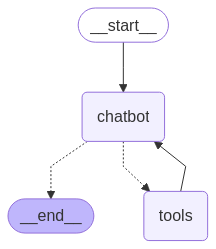

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
#与您的聊天机器人互动


config = {"configurable": {"thread_id": "2"}}


user_input = (
    "I'm learning LangGraph. "
    "Could you do some research on it for me?"
)


# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
    

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_0_1124b302-9f52-4688-85e8-e016349dc888)
 Call ID: call_0_1124b302-9f52-4688-85e8-e016349dc888
  Args:
    query: LangGraph
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient

In [13]:
snapshot = graph.get_state(config)
snapshot.next

()

In [ ]:
# replay

to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2: #指定要回放的状态的序号
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [18]:
#从检查点恢复

print(to_replay.next)
print(to_replay.config)


('tools',)
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f036bc4-23b2-6de4-8001-0145d4bbc81e'}}


In [ ]:
# 从某个时刻加载状态

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()
        

dict_items([('messages', [HumanMessage(content='Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.', additional_kwargs={}, response_metadata={}, id='6a9ae8cf-7eb3-4842-a4a4-2d2f8159f5db'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_fdff2329-f42d-42c8-ba5f-f1bd1ab74c19', 'function': {'arguments': '{"query":"LangGraph release date"}', 'name': 'tavily_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1362, 'total_tokens': 1385, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1344}, 'prompt_cache_hit_tokens': 1344, 'prompt_cache_miss_tokens': 18}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0425fp8', 'id': '11756e3e-6840-43b0-ad5d-8b9a84c2a344', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c0711883-3

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}